In [9]:
pd.read_csv('turner_data.csv').head()

,Producing depth (ft),Wellhead pressure (psi),Condensate gravity (API),Condensate make (bbl/MM),Water make (bbl/MM),Tubing ID (in.),Tubing OD (in.),Casing ID (in.),Test flow rate (Mcf/D),Well status during test
0,6529,108,64.3,9.6,12.4,2.041,NaN,NaN,568,Near L.U
1,2250,210,0.0,0.0,24.0,NaN,2.375,6.276,470,Loaded up
2,3077,280,0.0,0.0,28.0,NaN,2.375,4.974,500,Loaded up
3,3278,315,50.0,10.0,0.0,7.386,NaN,NaN,5740,Loaded up
4,6739,400,NaN,0.0,18.0,1.995,NaN,NaN,417,Near L.U


In [8]:
P_wh = 1150            # Wellhead presure (psia)
sg_gas = 0.6           # Specific gravity of gas, where SG of water = 1
T = 120                # Downhole temperature (F). Geothermal gradient of 1.5F/100ft can be used
Z = 0.90               # Gas deviation factor
density_liquid = 45    # Density of liquid (lbm/ft^3). May assumed to be 45
surface_tension = 20   # Surface tension of liquid (dyne/cm). May assumed to be 20 if condensate
A_effective = 15.9043  # Effective flowarea. π * r^2 if tubular flow, π * (r_outer^2 - r_inner^2) if annular flow. 

# Gas Density
density_gas = gas_density(P_wh, sg_gas, T, Z)

# Gas Critical Velocity
Vc = turner_critical_velocity(density_gas, density_liquid, surface_tension, adjusted=True)

# Gas Critical Flowrate 
Qc = critical_flowrate(Vc, P_wh, A_effective, T=T, Z=Z)

Qc

4032.8101890456073

# Implementation of Various Gas Well Liquid Loading Prediction Models In Python (Turner, Coleman, Guo, and ???) For Vertical And Horizontal Wells

In [90]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import gascompressibility as gc
import scipy

In [10]:
def API_to_density(API, water_density=62.416):
    '''
    :param API: API gravity of fluid
    :param water_density: Density of water (lbs/ft^3)
    :return: Fluid density (lbs/ft^3)
    '''

    sg = 141.5 / (API + 131.5)
    fluid_density = water_density / sg

    return fluid_density

In [11]:
def gas_density(P_wh, sg_gas=0.6, T=120, Z=0.9):

    '''
    Gas density equation based the book, Gas Well Deliquification 3rd Edition p. 435 (Lea and Rowlan, 2019)
    The optional parameters (gas_g, T, and Z) are pre-filled with typical values recommended by Turner et al. (1969).
    :param P_wh: Wellhead pressure (psia)
    :param gas_g: Gas specific gravity (dimensionless)
    :param T: Temperature (F)
    :param Z: Gas deviation factor, Z (dimensionless)
    :return:
    '''
    
    rho_gas = 2.715 * sg_gas * P_wh / ((460 + T) * Z)

    return rho_gas

In [12]:
def turner_critical_velocity(density_gas, density_liquid=45, surface_tension=20, adjusted=True):
    '''
    :param gas_density: Density of gas (lbm/ft^3)
    :param liquid_density:  Density of liquid (lbm/ft^3). According to Turner et al 1969, it may assumed to be 45 if condensate, and 67 if water.
    :param surface_tension: Surface tension (dyne/cm). According to Turner et al 1969, it may assumed to be 20 if condensate, and 60 if water.
    :param adjusted: Applies adjusted Turner rate if =True by increasing the velocity by 20%
    :return: Critical velocity of fluid required to lift well (ft/s)
    '''
    
    Vc = 1.593 * ((density_liquid - density_gas) / density_gas**2 * surface_tension)**(1/4)
    if adjusted:
        Vc = Vc * 1.2

    return Vc

In [41]:
def critical_flowrate(Vc, P_wh, A_effective, T=120, Z=0.9):
    '''
    :param Vc: Critical Velocity of fluid required to lift well (ft/s)
    :param P_wh: Wellhead pressure (psia)
    :param A_effective: Effective flowarea. π * r^2 if tubular flow, π * (r_outer^2 - r_inner^2) if annular flow. 
    :param T: Temperature (F)
    :param Z: Gas deviation factor, Z (dimensionless)
    :return: Critical flowrate fluid required to lift well (MCF/day)
    '''
    
    A_effective = A_effective / 144    # unit conversion from square inches to square feet
    T = (T - 32) + 491.67              # unit conversion from Fahrenheit to Rankine
    
    Qc = (3.06 * P_wh * Vc * A_effective) / (T * Z) * 1000
    
    return Qc

In [88]:
def calc_Belfroid_multiplier(degrees):
    return np.sin(np.deg2rad(1.7 * (90-degrees))) ** 0.38 / 0.74

In [91]:
scipy.optimize.fmin(lambda x: -calc_Belfroid_multiplier(x), 0)

Optimization terminated successfully.
         Current function value: -1.351351
         Iterations: 35
         Function evaluations: 70


array([37.0588125])

In [82]:
7.189 / 5.464

1.3157027818448022

In [8]:
def calc_eff_area(idt=2.375, idc=4.5, flowtype='tubular'):
    rt = idt/2
    rc = idc/2
    if flowtype == 'tubular':
        area = np.pi * rt ** 2
    elif flowtype == 'annular':
        area = np.pi * (rc ** 2 - rt ** 2)
    return area

In [21]:
def calc_downhole_T(tvd, surf_T=75, gradient=1.2):
    '''
    gradient: F/100ft
    '''
    return surf_T + gradient * tvd / 100

In [26]:
P_wh = 115            # Wellhead presure (psia)
sg_gas = 0.6           # Specific gravity of gas, where SG of water = 1
T = 120                # Downhole temperature (F). Geothermal gradient of 1.5F/100ft can be used
Z = 0.90               # Gas deviation factor
density_liquid = 45    # Density of liquid (lbm/ft^3). May assumed to be 45
surface_tension = 20   # Surface tension of liquid (dyne/cm). May assumed to be 20 if condensate
A_effective = 15.9043  # Effective flowarea. π * r^2 if tubular flow, π * (r_outer^2 - r_inner^2) if annular flow. 

# Gas Density
density_gas = gas_density(P_wh, sg_gas, T, Z)

# Gas Critical Velocity
Vc = turner_critical_velocity(density_gas, density_liquid, surface_tension, adjusted=True)

# Gas Critical Flowrate 
Qc = critical_flowrate(Vc, P_wh, A_effective, T=T, Z=Z)

Qc

1299.45750559945

In [51]:
def coleman_critical_velocity(P_wh, liquid='water'):
    if liquid == 'condensate':
        return 3.369 * (45 - 0.0031 * P_wh) ** 0.25 /(0.0031 * P_wh) ** 0.5
    elif liquid == 'water':
        return 4.434 * (67 - 0.0031 * P_wh) ** 0.25 /(0.0031 * P_wh) ** 0.5
    else:
        raise TypeError('Wrong input for liquid type. "condensate" and "water" are supported')

In [6]:
def belfroid_critical_multiplier(angle):
    return (np.sin(1.7 * (90 - angle))) ** 0.38 / 0.740767

In [32]:
coleman_critical_velocity(P_wh, liquid='water')

21.218045238795078

### colman calculator

In [66]:
P_wh = 100            # Wellhead presure (psia)
sg_gas = 0.7           # Specific gravity of gas, where SG of water = 1
T = 140 # Downhole temperature (F). Geothermal gradient of 1.2F/100ft can be used
A_effective = calc_eff_area(idt=1.995, flowtype='tubular')
Z = gc.calc_z(sg=sg_gas, P=P_wh, T=T)

print('Z=', Z)

# Gas Critical Velocity
Vc = coleman_critical_velocity(P_wh, liquid='water')

# Gas Critical Flowrate 
Qc = critical_flowrate(Vc, P_wh, A_effective, T=T, Z=Z)

Z= 0.9865662958795649


In [67]:
P_wh = 200            # Wellhead presure (psia)
sg_gas = 0.7           # Specific gravity of gas, where SG of water = 1
T = 140 # Downhole temperature (F). Geothermal gradient of 1.2F/100ft can be used
A_effective = calc_eff_area(idt=2.441, flowtype='tubular')
Z = gc.calc_z(sg=sg_gas, P=P_wh, T=T)

print('Z=', Z)

# Gas Critical Velocity
Vc = coleman_critical_velocity(P_wh, liquid='water')

# Gas Critical Flowrate 
Qc = critical_flowrate(Vc, P_wh, A_effective, T=T, Z=Z)

Qc

Z= 0.9750080213498471


546.7679064832756

In [49]:
gc.calc_z(sg=0.7, P=150, T=T)

0.9807675146765485

In [50]:
gc.calc_z(sg=0.7, P=1000, T=T)

0.8915073663311958

In [22]:
calc_downhole_T(tvd=5000, surf_T=75, gradient=1.2)

135.0

In [18]:
def calc_eff_area(odt=2.375, idt=1.995, idc=3.985, flowtype='tubular'):
    rt = idt/2
    rc = idc/2
    if flowtype == 'tubular':
        area = np.pi * rt ** 2
    elif flowtype == 'annular':
        area = np.pi * (rc ** 2 - rt ** 2)
    return area

In [19]:
calc_eff_area(flowtype='annular') / 144

0.06490552238932162

In [4]:
critical_flowrate(8.2, 100, 0.11 * 144, T=140, Z=0.88)

6014.933213267296

In [30]:
0.1585 * P_wh * 2.375 ** 2 * (67-0.0031 * P_wh) ** 0.25/(0.0031 * P_wh) ** 0.5

491.9987700582134

In [39]:
0.25 / 3.14

0.07961783439490445

In [34]:
2.375 ** 2

5.640625

In [35]:
(2.375 / 2 ) ** 2

1.41015625

In [37]:
0.25 * 3.14

0.785

In [36]:
5.64/1.41

4.0

In [25]:
calc_eff_area(rt=2.375, flowtype='tubular')

17.720546061654925

In [16]:
belfroid_critical_multiplier(90)

0.0

In [18]:
(np.sin(1.7 * (90 - 90)))

0.0

In [21]:
def calc_effective_area(t=None, c=None, flow='annular'):
    if flow == 'annular':
        return np.pi * ((c/2) ** 2 - (t/2) ** 2)
    elif flow == 'tubular':
        return np.pi * (t/2) ** 2

In [24]:
P_wh = 90
A_effective = calc_effective_area(c=5.5, t=2+3/8, flow='annular')
T = 120
Z = 0.9

# Gas Critical Velocity
Vc = coleman_critical_velocity(P_wh) 

# Gas Critical Flowrate 
Qc = critical_flowrate(Vc, P_wh, A_effective, T=T, Z=Z)
Qc

1168.67932522769

In [30]:
P_wh = 80
A_effective = calc_effective_area(c=4.5, t=2+3/8, flow='annular')
T = 120
Z = 0.9

# Gas Critical Velocity
Vc = coleman_critical_velocity(P_wh) 

# Gas Critical Flowrate 
Qc = critical_flowrate(Vc, P_wh, A_effective, T=T, Z=Z)
Qc

654.2223675479821

## Effects of Effective Flow Area

In [348]:
# inputs
sg_gas = 0.6        
T = 120                
Z = 0.9               
density_liquid = 45    
surface_tension = 20  

tubing_IDs = [3.958, 2.992, 2.441, 1.995, 1.751]  # Used to calculate effective flow area
tubing_ODs = [4.5, 3.5, 2.875, 2.375, 2.0675]     # Used for plot labeling, not used for calculation

x = np.linspace(0, 500, 16)[1:]
crit_rates_IDs = []
for tubing_ID in tubing_IDs:
    crit_rates = []
    for item in x:

        P_wh = item
        A_effective = np.pi * (tubing_ID / 2) ** 2

        density_gas = gas_density(P_wh, sg_gas, T, Z)
        Vc = turner_critical_velocity(density_gas, density_liquid, surface_tension, adjusted=True)
        Qc = critical_flowrate(Vc, P_wh, A_effective, T=T, Z=Z)

        crit_rates.append(Qc)
        
    crit_rates_IDs.append(crit_rates)

Text(1.06, 1.07, '')

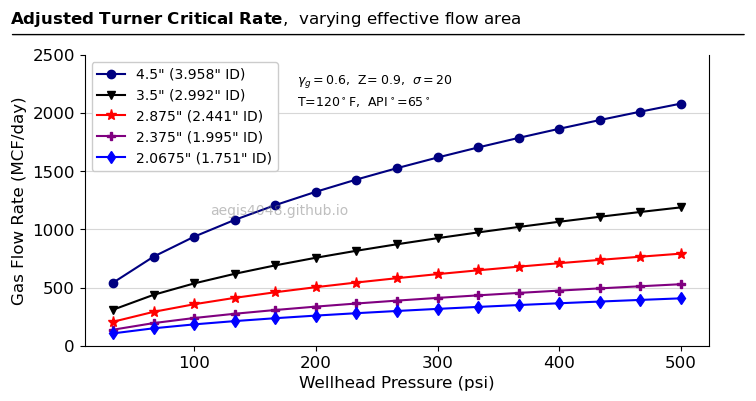

In [349]:
def setbold(txt):
    return ' '.join([r"$\bf{" + item + "}$" for item in txt.split(' ')])

fig, ax = plt.subplots(figsize=(7, 3.5))

label_fontsize = 12

colors = ['navy', 'k', 'r', 'purple', 'blue']
markers = ['.', 'v', '*', 'P', 'd']
m_sizes = [12, 6, 8, 6, 6]

for i, crit_rates in enumerate(crit_rates_IDs):
    label = '%g" (%g" ID)' % (tubing_ODs[i], tubing_IDs[i])
    ax.plot(x, crit_rates, color=colors[i], marker=markers[i], markersize=m_sizes[i], label=label)
    
ax.set_ylim(0, 2500)

ax.grid(axis='y', alpha=0.5)
ax.yaxis.get_major_ticks()[-1].gridline.set_visible(False)
ax.spines.top.set_visible(False)

fig.set_facecolor("white")
fig.tight_layout()

ax.set_ylabel('Gas Flow Rate (MCF/day)', fontsize=label_fontsize)
ax.set_xlabel('Wellhead Pressure (psi)', fontsize=label_fontsize)
ax.tick_params(axis='x', labelsize=label_fontsize)
ax.tick_params(axis='y', labelsize=label_fontsize)

ax.legend(fontsize=10, ncol=1, loc='upper left', framealpha=1)
ax.text(0.2, 0.45, 'aegis4048.github.io', fontsize=10, transform=ax.transAxes, color='grey', alpha=0.5)


api_gravity = round(141.5/(density_liquid/62.416) - 131.5)  # water density = 62.416

ax.text(0.34, 0.94, r'$\gamma_{g}=%g$' % sg_gas + ',  Z= %g,  ' % Z + r'$\sigma=%g$' % surface_tension, 
        fontsize=9, ha='left', va='top',transform=ax.transAxes, color='k')
ax.text(0.34, 0.86, 'T=%g$^\circ$F' % T + ',  API$^\circ$=%g$^\circ$' % api_gravity, 
        fontsize=9, ha='left', va='top',transform=ax.transAxes, color='k')

ax.set_title(setbold('Adjusted Turner Critical Rate') + ',  varying effective flow area', fontsize=12, pad=10, x=0.29, y=1.06)
ax.annotate('', xy=(-0.12, 1.07), xycoords='axes fraction', xytext=(1.06, 1.07), arrowprops=dict(arrowstyle="-", color='k'))

## Effects of Gas Gravity

In [356]:
# inputs
T = 120                
Z = 0.9               
density_liquid = 45    
surface_tension = 20  
tubing_ID = 3.958

sg_gas_s = [0.5, 0.6, 0.7, 0.8, 0.9]

x = np.linspace(0, 500, 16)[1:]
crit_rates_IDs = []
for sg_gas in sg_gas_s:
    crit_rates = []
    for item in x:
        P_wh = item
        A_effective = np.pi * (tubing_ID / 2) ** 2

        density_gas = gas_density(P_wh, sg_gas, T, Z)
        Vc = turner_critical_velocity(density_gas, density_liquid, surface_tension, adjusted=True)
        Qc = critical_flowrate(Vc, P_wh, A_effective, T=T, Z=Z)

        crit_rates.append(Qc)
        
    crit_rates_IDs.append(crit_rates)

Text(1.06, 1.07, '')

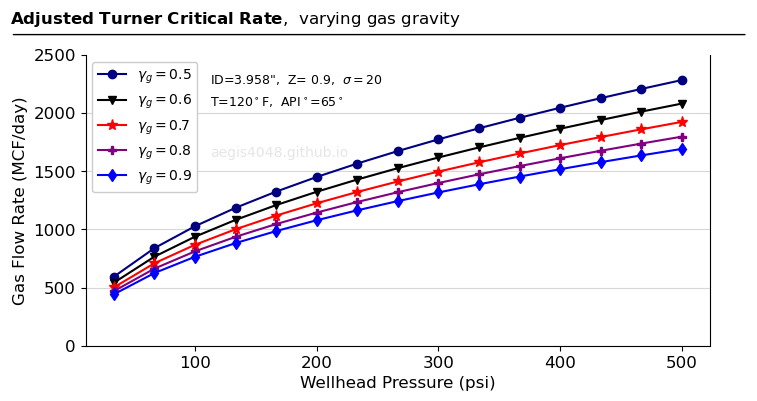

In [357]:
def setbold(txt):
    return ' '.join([r"$\bf{" + item + "}$" for item in txt.split(' ')])

fig, ax = plt.subplots(figsize=(7, 3.5))

label_fontsize = 12

colors = ['navy', 'k', 'r', 'purple', 'blue']
markers = ['.', 'v', '*', 'P', 'd']
m_sizes = [12, 6, 8, 6, 6]

for i, crit_rates in enumerate(crit_rates_IDs):
    label = r'$\gamma_{g} = %g$' % sg_gas_s[i]
    ax.plot(x, crit_rates, color=colors[i], marker=markers[i], markersize=m_sizes[i], label=label)
    
ax.set_ylim(0, 2500)

ax.grid(axis='y', alpha=0.5)
ax.yaxis.get_major_ticks()[-1].gridline.set_visible(False)
ax.spines.top.set_visible(False)

fig.set_facecolor("white")
fig.tight_layout()

ax.set_ylabel('Gas Flow Rate (MCF/day)', fontsize=label_fontsize)
ax.set_xlabel('Wellhead Pressure (psi)', fontsize=label_fontsize)
ax.tick_params(axis='x', labelsize=label_fontsize)
ax.tick_params(axis='y', labelsize=label_fontsize)

ax.legend(fontsize=10, ncol=1, loc='upper left', framealpha=1)
ax.text(0.2, 0.65, 'aegis4048.github.io', fontsize=10, transform=ax.transAxes, color='grey', alpha=0.2)


ax.text(0.2, 0.94, r'ID=%g"' % tubing_ID + ',  Z= %g,  ' % Z + r'$\sigma=%g$' % surface_tension, 
        fontsize=9, ha='left', va='top',transform=ax.transAxes, color='k')
ax.text(0.2, 0.86, 'T=%g$^\circ$F' % T + ',  API$^\circ$=%g$^\circ$' % api_gravity, 
        fontsize=9, ha='left', va='top',transform=ax.transAxes, color='k')


ax.set_title(setbold('Adjusted Turner Critical Rate') + ',  varying gas gravity', fontsize=12, pad=10, x=0.24, y=1.06)
ax.annotate('', xy=(-0.12, 1.07), xycoords='axes fraction', xytext=(1.06, 1.07), arrowprops=dict(arrowstyle="-", color='k'))

## Effects of Liquid API Gravity

In [358]:
def API_to_density(API, water_density=62.416):
    '''
    :param API: API gravity of fluid
    :param water_density: Density of water (lbs/ft^3)
    :return: Fluid density (lbs/ft^3)
    '''

    sg = 141.5 / (API + 131.5)
    fluid_density = water_density / sg

    return fluid_density


# inputs
sg_gas = 0.6
T = 120                
Z = 0.9               
surface_tension = 20  
tubing_ID = 3.958

APIs = [10, 30, 50, 70, 90]                                 # Used to be converted into liquid density. 
density_liquid_arr = [API_to_density(API) for API in APIs]  # Liquid density (lbs/ft^3)

x = np.linspace(0, 500, 16)[1:]
crit_rates_IDs = []
for density_liquid in density_liquid_arr:
    crit_rates = []
    for item in x:
        P_wh = item
        A_effective = np.pi * (tubing_ID / 2) ** 2

        density_gas = gas_density(P_wh, sg_gas, T, Z)
        Vc = turner_critical_velocity(density_gas, density_liquid, surface_tension, adjusted=True)
        Qc = critical_flowrate(Vc, P_wh, A_effective, T=T, Z=Z)

        crit_rates.append(Qc)
        
    crit_rates_IDs.append(crit_rates)

Text(1.06, 1.07, '')

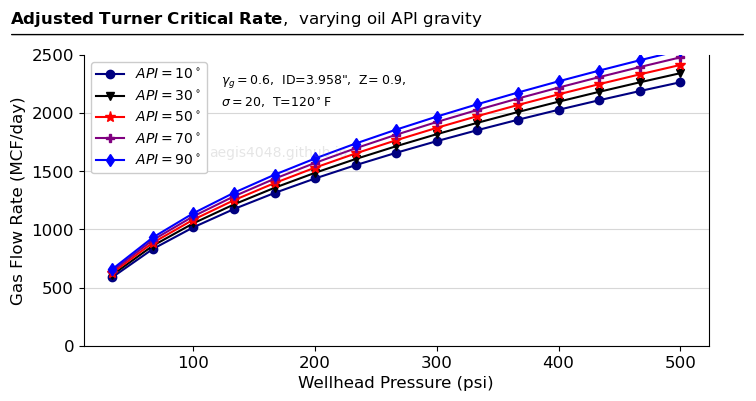

In [369]:
def setbold(txt):
    return ' '.join([r"$\bf{" + item + "}$" for item in txt.split(' ')])

fig, ax = plt.subplots(figsize=(7, 3.5))

label_fontsize = 12

colors = ['navy', 'k', 'r', 'purple', 'blue']
markers = ['.', 'v', '*', 'P', 'd']
m_sizes = [12, 6, 8, 6, 6]

for i, crit_rates in enumerate(crit_rates_IDs):
    label = r'$API=%g^\circ$' % APIs[i]
    ax.plot(x, crit_rates, color=colors[i], marker=markers[i], markersize=m_sizes[i], label=label)
    
ax.set_ylim(0, 2500)

ax.grid(axis='y', alpha=0.5)
ax.yaxis.get_major_ticks()[-1].gridline.set_visible(False)
ax.spines.top.set_visible(False)

fig.set_facecolor("white")
fig.tight_layout()

ax.set_ylabel('Gas Flow Rate (MCF/day)', fontsize=label_fontsize)
ax.set_xlabel('Wellhead Pressure (psi)', fontsize=label_fontsize)
ax.tick_params(axis='x', labelsize=label_fontsize)
ax.tick_params(axis='y', labelsize=label_fontsize)

ax.legend(fontsize=10, ncol=1, loc='upper left', framealpha=1)
ax.text(0.2, 0.65, 'aegis4048.github.io', fontsize=10, transform=ax.transAxes, color='grey', alpha=0.2)


ax.text(0.22, 0.94, r'$\gamma_{g}=%g$' % sg_gas + r',  ID=%g"' % tubing_ID + ',  Z= %g,  ' % Z, 
        fontsize=9, ha='left', va='top',transform=ax.transAxes, color='k')
ax.text(0.22, 0.86, r'$\sigma=%g$' % surface_tension + ',  T=%g$^\circ$F' % T, 
        fontsize=9, ha='left', va='top',transform=ax.transAxes, color='k')


ax.set_title(setbold('Adjusted Turner Critical Rate') + ',  varying oil API gravity', fontsize=12, pad=10, x=0.26, y=1.06)
ax.annotate('', xy=(-0.12, 1.07), xycoords='axes fraction', xytext=(1.06, 1.07), arrowprops=dict(arrowstyle="-", color='k'))

## Citations

Turner, R.G., Hubbard, M.G. and Dukler, A.E.: “Analysis and Prediction of Minimum Flow Rate for the Continuous
Removal of Liquids from Gas Wells,” J. Pet. Tech. (Nov., 1969) 1475-82.

Lea, J.F., Jr., and Rowlan, Lynn.: <i>Gas Well Deliquificaiton</i>, 3rd ed, Elsvier, New York (2019) 435.